# Calculate Portfolio Value

* Calculate the portfolio value over time of a trader


In [2]:
import os
from copy import deepcopy
import asyncio
import requests
import pandas as pd
import numpy as np
import json
from gql import Client, gql
from gql.transport.aiohttp import AIOHTTPTransport
from decimal import Decimal
from dotenv import load_dotenv
import matplotlib

load_dotenv()


True

In [3]:
## constants
INFURA_KEY = os.getenv('INFURA_KEY')

# mainnet
MAIN_ENDPOINT = 'https://api.thegraph.com/subgraphs/name/kwenta/optimism-main'
SUBGRAPH_ENDPOINT = 'https://api.thegraph.com/subgraphs/name/tburm/optimism-perps'
RPC_ENDPOINT = f'https://optimism-mainnet.infura.io/v3/{INFURA_KEY}'

# testnet
# SUBGRAPH_ENDPOINT = 'https://api.thegraph.com/subgraphs/name/kwenta/optimism-goerli-perps'
# RPC_ENDPOINT = f'https://optimism-kovan.infura.io/v3/{INFURA_KEY}'


In [4]:
# functions
convertDecimals = lambda x: Decimal(x) / Decimal(10**18)

def clean_df(df, decimal_cols):
    for col in decimal_cols:
        if col in df.columns:
            df[col] = df[col].apply(convertDecimals)
        else:
            print(f"{col} not in DataFrame")
    return df

async def run_query(query, params, endpoint=SUBGRAPH_ENDPOINT):
    transport = AIOHTTPTransport(url=endpoint)

    async with Client(
        transport=transport,
        fetch_schema_from_transport=True,
    ) as session:

        # Execute single query
        query = query

        result = await session.execute(query, variable_values=params)
        df = pd.DataFrame(result)
        return df

async def run_recursive_query(query, params, accessor, endpoint=SUBGRAPH_ENDPOINT):
  transport = AIOHTTPTransport(url=endpoint)

  async with Client(
      transport=transport,
      fetch_schema_from_transport=True,
  ) as session:
    done_fetching = False
    all_results = []
    while not done_fetching:
      result = await session.execute(query, variable_values=params)
      if len(result[accessor]) > 0:
        all_results.extend(result[accessor])
        params['last_id'] = all_results[-1]['id']
      else:
        done_fetching = True
    
    df = pd.DataFrame(all_results)
    return df


In [5]:
# queries
position_query = gql("""
query positions(
    $last_id: ID!
  ) {
    futuresPositions(
      where: {
        id_gt: $last_id
      }
      first: 1000
     ) {
      id
      account
      asset
      initialMargin
      size
      entryPrice
      avgEntryPrice
      lastPrice
      exitPrice
      pnl
      pnlWithFeesPaid
      openTimestamp
      closeTimestamp
      feesPaid
      netFunding
      isLiquidated
      isOpen
      margin
      netTransfers
      totalDeposits
      totalVolume
    }  
}
""")

trade_query = gql("""
query trades(
    $last_id: ID!
  ) {
    futuresTrades(
      where: {
        id_gt: $last_id
      }
      first: 1000
     ) {
      id
      account
      timestamp
      asset
      marketKey
      orderType
      price
      margin
      positionId
      feesPaid
      pnl
      size
      positionSize
      positionClosed
    }  
}
""")

transfer_query = gql("""
query transfers(
    $last_id: ID!
  ) {
		futuresMarginTransfers(
      where: {
        id_gt: $last_id
      }
			first: 1000
		) {
			id
			timestamp
			account
			market
			size
			asset
			txHash
		}
}
""")
                     
balance_query = gql("""
query balances(
    $last_id: ID!
    $account: String!
  ) {
		synthBalances(
      where: {
        id_gt: $last_id,
        synth_: {symbol: "sUSD"},
        account: $account
      }
			first: 1000
		) {
      id
      timestamp
      amount
      account
		}
}
""")


### Run a query

In [6]:
position_params = {
    'last_id': ''
}

position_cols = [
    'avgEntryPrice',
    'entryPrice',
    'exitPrice',
    'feesPaid',
    'initialMargin',
    'lastPrice',
    'margin',
    'netFunding',
    'netTransfers',
    'pnl',
    'pnlWithFeesPaid',
    'size',
    'totalDeposits',
    'totalVolume'
]

df_position = await run_recursive_query(position_query, position_params, 'futuresPositions')
df_position = df_position.replace({None: np.nan})
df_position = clean_df(df_position, position_cols)

In [7]:
trade_params = {
    'last_id': ''
}

trade_cols = [
    'price',
    'margin',
    'feesPaid',
    'pnl',
    'size',
    'positionSize',
]

df_trade = await run_recursive_query(trade_query, trade_params, 'futuresTrades')
df_trade = df_trade.replace({None: np.nan})
df_trade = clean_df(df_trade, trade_cols)


In [8]:
transfer_params = {
    'last_id': ''
}

transfer_cols = [
    'size',
]

df_transfer = await run_recursive_query(transfer_query, transfer_params, 'futuresMarginTransfers')
df_transfer = df_transfer.replace({None: np.nan})
df_transfer = clean_df(df_transfer, transfer_cols)

In [9]:
trader = str.lower('0x3271a213e0c97f6682ef4ae1701315cea8df5c71')
balance_params = {
    'last_id': '',
    'account': trader
}

df_balance = await run_recursive_query(balance_query, balance_params, 'synthBalances', endpoint=MAIN_ENDPOINT)
df_balance = df_balance.replace({None: np.nan})
df_balance['amount'] = df_balance['amount'].apply(lambda x: Decimal(x))


## Limit to one trader

In [10]:
# filter trade data
df_trader_trade = df_trade.loc[(df_trade['account'] == trader), ['account', 'timestamp', 'asset', 'margin']]
df_trader_trade['type'] = 'trade'

# filter transfer data
df_trader_transfer = df_transfer.loc[(df_transfer['account'] == trader), ['account', 'timestamp', 'asset', 'size']]
df_trader_transfer['type'] = 'transfer'

# filter balance data
df_trader_balance = df_balance.loc[:, ['timestamp', 'amount', 'account']]
df_trader_balance['type'] = 'balance'
df_trader_balance['asset'] = 'sUSD'


# combine them
df_trader = pd.concat([df_trader_trade, df_trader_transfer], axis=0).sort_values('timestamp').reset_index()
df_trader.head(20)


,index,account,timestamp,asset,margin,type,size
0,1671,0x3271a213e0c97f6682ef4ae1701315cea8df5c71,1671583381,0x73455448000000000000000000000000000000000000...,NaN,transfer,100
1,15713,0x3271a213e0c97f6682ef4ae1701315cea8df5c71,1671583487,0x73455448000000000000000000000000000000000000...,99,trade,NaN
2,5855,0x3271a213e0c97f6682ef4ae1701315cea8df5c71,1671766762,0x73455448000000000000000000000000000000000000...,92.397589656548541052,trade,NaN
3,5736,0x3271a213e0c97f6682ef4ae1701315cea8df5c71,1671817212,0x73455448000000000000000000000000000000000000...,NaN,transfer,-92.144881599078565423
4,3686,0x3271a213e0c97f6682ef4ae1701315cea8df5c71,1671885821,0x73455448000000000000000000000000000000000000...,NaN,transfer,200000
5,4348,0x3271a213e0c97f6682ef4ae1701315cea8df5c71,1671887081,0x73455448000000000000000000000000000000000000...,199999,trade,NaN
6,8949,0x3271a213e0c97f6682ef4ae1701315cea8df5c71,1671887666,0x73455448000000000000000000000000000000000000...,199671.892089427456197804,trade,NaN
7,13117,0x3271a213e0c97f6682ef4ae1701315cea8df5c71,1671887756,0x73455448000000000000000000000000000000000000...,199653.539144689309336741,trade,NaN
8,6395,0x3271a213e0c97f6682ef4ae1701315cea8df5c71,1671888071,0x73455448000000000000000000000000000000000000...,199448.036532595059649015,trade,NaN
9,15940,0x3271a213e0c97f6682ef4ae1701315cea8df5c71,1671888326,0x73455448000000000000000000000000000000000000...,199257.847467493584816876,trade,NaN


In [11]:
# calculate the portfolio value at various points
portfolio_values = {}

last_portfolio_value = None
for index, row in df_trader.iterrows():
    if index > 0:
        portfolio_value = deepcopy(last_portfolio_value)
        portfolio_value['timestamp'] = row['timestamp']
    else:
        portfolio_value = {
            'timestamp': row['timestamp'],
            'account': row['account'],
        }

    if row['type'] == 'trade':
        portfolio_value[row['asset']] = row['margin']
    elif row['type'] == 'transfer':
        if row['asset'] in portfolio_value.keys():
            asset_margin = portfolio_value[row['asset']] + row['size']
        else:
            asset_margin = row['size']
        portfolio_value[row['asset']] = asset_margin
    elif row['type'] == 'balance':
        portfolio_value['sUSD'] = np.float64(row['amount'])

    asset_keys = [key for key in portfolio_value.keys() if key not in ['account', 'timestamp']]
    portfolio_values[portfolio_value['timestamp']] = portfolio_value

    last_portfolio_value = deepcopy(portfolio_value)

df_portfolio = pd.DataFrame.from_dict(portfolio_values, orient='index').fillna(0)
df_portfolio['futures'] = df_portfolio[[col for col in df_portfolio.columns if col not in ['account', 'timestamp', 'sUSD']]].sum(axis=1)

<Axes: xlabel='timestamp'>

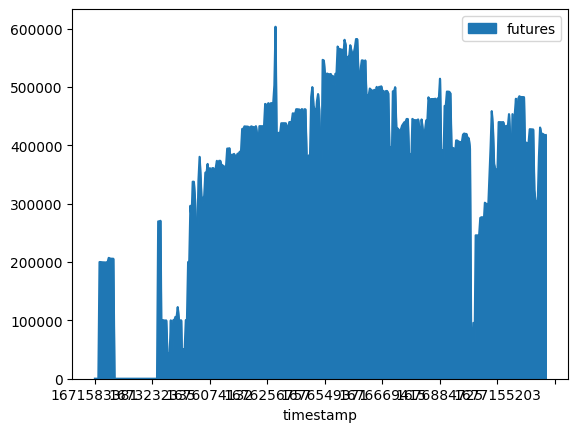

In [12]:
df_portfolio.plot(kind='area', x='timestamp', y=['futures'], stacked=True)



In [16]:
df_trader.reset_index().to_csv('./output/test_trader.csv')
df_portfolio.reset_index().to_csv('./output/test_portfolio.csv')
